In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
from IPython.display import display, Markdown
import matplotlib.colors as mcolors

In [2]:
# Display the full DataFrame without truncation
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_rows', None)     # Show all rows

## General Overview

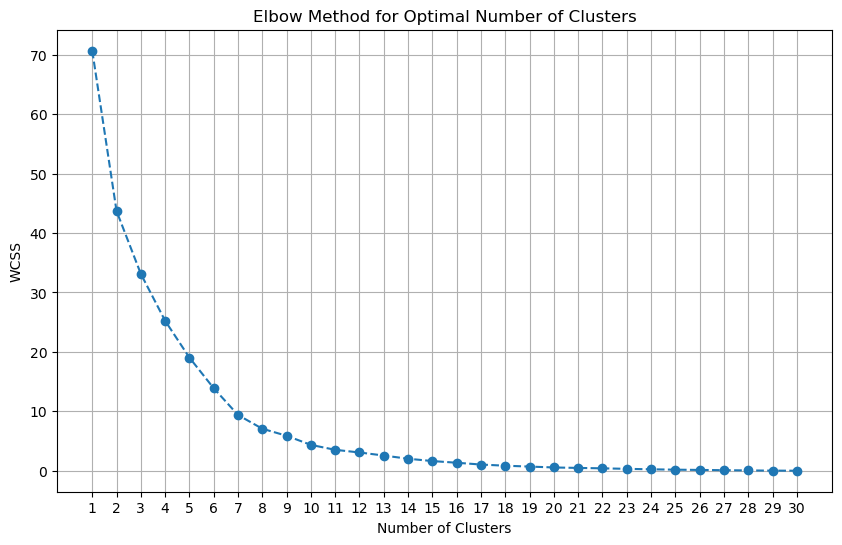

Enter the optimal number of clusters (as observed from the elbow plot): 8


,TEAM,NetRtg,OffRtg,DefRtg,Cluster
0,Osceola Magic,1.5 (12),111.5 (13),110.0 (15),The Average
1,Motor City Cruise,-1.7 (18),109.3 (19),111.0 (18),The Average
2,Long Island Nets,2.0 (10),111.7 (11),109.7 (13),The Average
3,Valley Suns,-0.1 (17),110.0 (16),110.1 (16),The Average
4,Greensboro Swarm,1.7 (11),109.3 (19),107.6 (7),The Average
5,Maine Celtics,0.2 (15),108.5 (22),108.3 (8),The Average
6,Sioux Falls Skyforce,1.2 (13),110.6 (14),109.4 (11),The Average
7,Ciudad de Mexico Capitanes,4.8 (4),107.9 (24),103.1 (2),The Greats (Defensive Dynamos)
8,College Park Skyhawks,3.7 (7),110.1 (15),106.4 (6),The Greats (Defensive Dynamos)
9,Oklahoma City Blue,3.3 (8),107.9 (24),104.6 (3),The Greats (Defensive Dynamos)


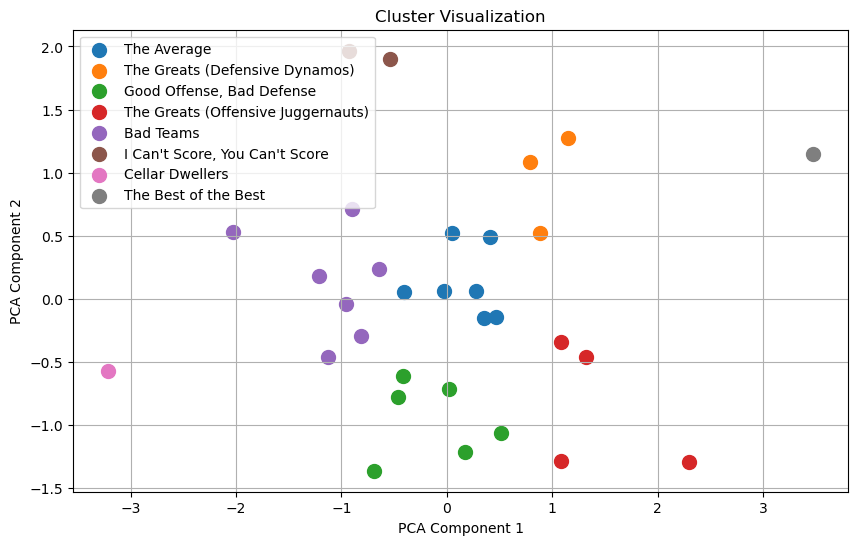

In [7]:
import os
import warnings
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from threadpoolctl import threadpool_limits
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
import time
from IPython.display import display

# Suppress MKL-related warning
warnings.filterwarnings("ignore", message="KMeans is known to have a memory leak", category=UserWarning)

# Set environment variable for MKL threads (optional, but may help)
os.environ["OMP_NUM_THREADS"] = "1"

# Set up Selenium WebDriver
service = Service(r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe")  # Update with your path

#Mac file path
#"/Users/fadihaddad/Documents/chromedriver-mac-arm64/chromedriver"

#PC file path
#r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe"

options = Options()
options.add_argument('--headless')  # Run in headless mode
options.add_argument('--disable-gpu')
options.add_argument('--start-maximized')
driver = webdriver.Chrome(service=service, options=options)

# URL of the webpage to scrape
url = "https://stats.gleague.nba.com/teams/advanced/?sort=W&dir=-1&Season=2024-25&SeasonType=Regular%20Season"

# Load the webpage
driver.get(url)
time.sleep(10)  # Allow time for JavaScript to load

# Locate the table and extract its data
table_xpath = '//div[contains(@class, "nba-stat-table__overflow")]/table'
table_element = driver.find_element(By.XPATH, table_xpath)
table_html = table_element.get_attribute('outerHTML')
team_stats = pd.read_html(table_html)[0]  # Convert the table HTML into a pandas DataFrame
driver.quit()  # Close the WebDriver

# Keep only the specified columns
columns_to_keep = ['TEAM', 'OffRtg', 'DefRtg', 'NetRtg']
team_stats = team_stats[columns_to_keep]

# Rearrange columns in the specified order
column_order = ['TEAM', 'NetRtg', 'OffRtg', 'DefRtg']
team_stats = team_stats[column_order]

# Identify numeric columns
numeric_cols = team_stats.select_dtypes(include=['number']).columns

# Define weights for grouped statistics (used ONLY during clustering)
weights = {
    'NetRtg': 1.0,  # Higher weight for NetRtg
    'OffRtg': 0.8,
    'DefRtg': 0.8
}

# Standardize numeric data for clustering
scaler = StandardScaler()
scaled_data = scaler.fit_transform(team_stats[numeric_cols])

# Apply weights to the standardized data (affects clustering only)
weighted_scaled_data = scaled_data.copy()
for i, col in enumerate(numeric_cols):
    if col in weights:
        weighted_scaled_data[:, i] *= weights[col]

# Elbow Method: Compute WCSS for different numbers of clusters
wcss = []
max_clusters = 30  # Test up to 30 clusters
for i in range(1, max_clusters + 1):
    with threadpool_limits(limits=1, user_api='blas'):  # Limit MKL threads
        kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
        kmeans.fit(weighted_scaled_data)  # Use weighted scaled data
        wcss.append(kmeans.inertia_)  # WCSS (Within-Cluster Sum of Squares)

# Plot the elbow method
plt.figure(figsize=(10, 6))
plt.plot(range(1, max_clusters + 1), wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.xticks(range(1, max_clusters + 1))
plt.grid()
plt.show()

# Prompt user to enter the optimal number of clusters (based on the elbow chart)
optimal_clusters = int(input("Enter the optimal number of clusters (as observed from the elbow plot): "))

# Perform K-Means clustering
with threadpool_limits(limits=1, user_api='blas'):
    kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(weighted_scaled_data)  # Use weighted scaled data

# Add cluster labels to the DataFrame
df_with_ranks = team_stats.copy()  # Use original data for display
df_with_ranks['Cluster'] = cluster_labels

# Sort the DataFrame by the Cluster column in ascending order
df_with_ranks = df_with_ranks.sort_values(by='Cluster', ascending=True).reset_index(drop=True)

# Calculate ranks for numeric columns
invert_cols = ['DefRtg']  # Columns where lower values are better
ranks_data = {}

for col in numeric_cols:
    if col in invert_cols:
        ranks = df_with_ranks[col].rank(ascending=True, method='min').astype(int)
    else:
        ranks = df_with_ranks[col].rank(ascending=False, method='min').astype(int)
    df_with_ranks[col] = df_with_ranks[col].astype(str) + ' (' + ranks.astype(str) + ')'
    ranks_data[col] = ranks  # Store ranks for conditional formatting

# Define luminance function for text readability
def luminance(color):
    rgb = mcolors.hex2color(color)
    return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

# Define color_cells function for conditional formatting
def color_cells(row):
    colors = []
    for col in numeric_cols:
        rank = ranks_data[col].loc[row.name]
        max_rank = ranks_data[col].max()
        min_rank = ranks_data[col].min()
        # Normalize rank to 0-1 scale for color mapping
        norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
        color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Best ranks in green
        text_color = 'white' if luminance(color) < 0.5 else 'black'
        colors.append(f"background-color: {color}; color: {text_color};")
    return colors

# Apply the coloring logic to the sorted DataFrame
styled_df = df_with_ranks.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

# Rename clusters at the end
cluster_names = {
    0: "The Average", 
    1: "The Greats (Defensive Dynamos)", 
    2: "Good Offense, Bad Defense", 
    3: "The Greats (Offensive Juggernauts)", 
    4: "Bad Teams", 
    5: "I Can't Score, You Can't Score", 
    6: "Cellar Dwellers",
    7: "The Best of the Best"
}
df_with_ranks['Cluster'] = df_with_ranks['Cluster'].map(cluster_names)

# Display the styled DataFrame (sorted by clusters)
display(styled_df)

# Optional: Visualize the clusters using PCA
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(weighted_scaled_data)  # Use weighted scaled data for visualization

plt.figure(figsize=(10, 6))
for cluster, cluster_name in cluster_names.items():
    cluster_points = reduced_data[cluster_labels == cluster]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=cluster_name, s=100)  # Use names for the legend
plt.title('Cluster Visualization')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.grid()
plt.show()

## Offense

## Scoring

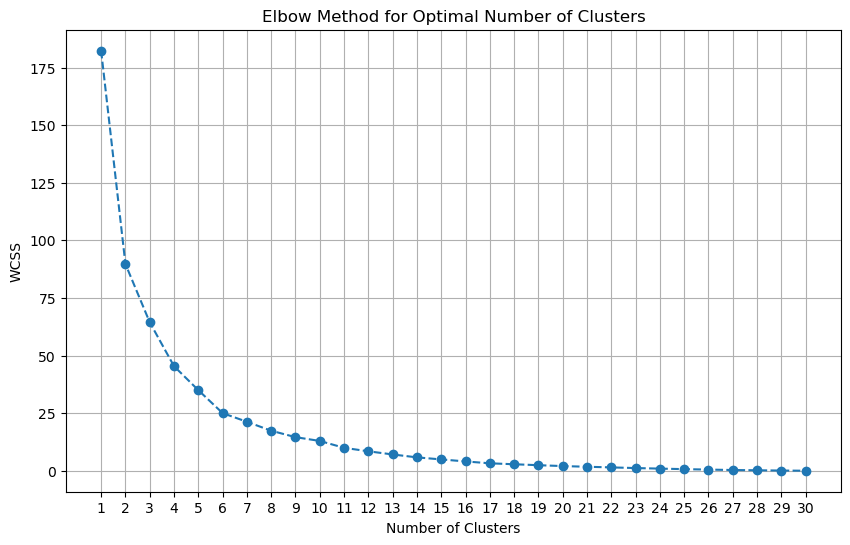

Enter the optimal number of clusters (as observed from the elbow plot): 6


,TEAM,%FGA 2PT,%FGA 3PT,%PTS PITP,%PTS 2PT- MR,%PTS 3PT,Cluster
0,Stockton Kings,57.2 (18),42.8 (14),43.7 (21),4.9 (10),38.4 (6),Three Point Focus
1,Salt Lake City Stars,55.1 (25),44.9 (6),41.9 (27),3.9 (19),37.4 (8),Three Point Focus
2,Wisconsin Herd,58.4 (13),41.6 (19),40.6 (29),5.4 (9),38.6 (5),Three Point Focus
3,Santa Cruz Warriors,56.4 (19),43.6 (12),42.7 (24),5.6 (8),36.5 (12),Three Point Focus
4,College Park Skyhawks,56.4 (19),43.6 (12),44.1 (18),4.8 (11),36.6 (11),Three Point Focus
5,Ciudad de Mexico Capitanes,56.3 (21),43.7 (10),40.0 (30),6.1 (7),37.4 (8),Three Point Focus
6,Oklahoma City Blue,55.0 (27),45.0 (5),43.2 (23),3.9 (19),35.9 (13),Three Point Focus
7,Austin Spurs,56.3 (21),43.7 (10),43.7 (21),4.2 (17),35.8 (15),Three Point Focus
8,Windy City Bulls,66.8 (2),33.2 (30),54.8 (1),4.6 (13),28.6 (28),90's Basketball (Two Point Heavy)
9,Long Island Nets,72.4 (1),27.6 (31),54.4 (2),4.3 (15),23.1 (31),90's Basketball (Two Point Heavy)


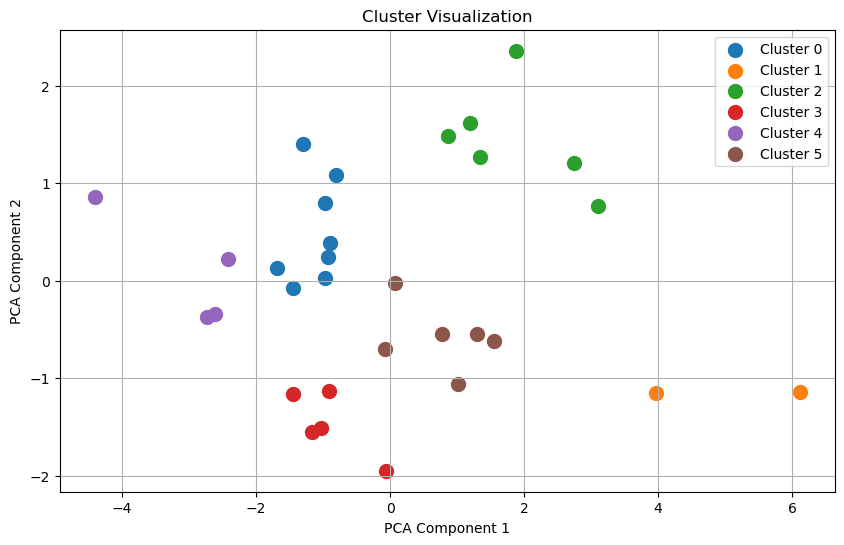

In [9]:
import os
import warnings
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from threadpoolctl import threadpool_limits
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
import time
from IPython.display import display

# Suppress MKL-related warning
warnings.filterwarnings("ignore", message="KMeans is known to have a memory leak", category=UserWarning)

# Set environment variable for MKL threads (optional, but may help)
os.environ["OMP_NUM_THREADS"] = "1"

# Set up Selenium WebDriver
service = Service(r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe")  # Update with your path

#Mac file path
#"/Users/fadihaddad/Documents/chromedriver-mac-arm64/chromedriver"

#PC file path
#r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe"

options = Options()
options.add_argument('--headless')  # Run in headless mode
options.add_argument('--disable-gpu')
options.add_argument('--start-maximized')
driver = webdriver.Chrome(service=service, options=options)

# URL of the webpage to scrape
url = "https://stats.gleague.nba.com/teams/scoring/?sort=W&dir=-1&Season=2024-25&SeasonType=Regular%20Season"

# Load the webpage
driver.get(url)
time.sleep(10)  # Allow time for JavaScript to load

# Locate the table and extract its data
table_xpath = '//div[contains(@class, "nba-stat-table__overflow")]/table'
table_element = driver.find_element(By.XPATH, table_xpath)
table_html = table_element.get_attribute('outerHTML')
team_stats = pd.read_html(table_html)[0]  # Convert the table HTML into a pandas DataFrame
driver.quit()  # Close the WebDriver

# Standardize column names: replace non-breaking spaces and strip whitespace
team_stats.columns = team_stats.columns.str.replace('\xa0', ' ', regex=False).str.strip()

# Keep only the specified columns
columns_to_keep = [
    'TEAM', '%FGA 2PT', '%FGA 3PT', '%PTS PITP', '%PTS 2PT- MR', '%PTS 3PT' #%PTS 2PT
]
team_stats = team_stats[columns_to_keep]

# Identify numeric columns
numeric_cols = team_stats.select_dtypes(include=['number']).columns

# Standardize numeric data for clustering
scaler = StandardScaler()
scaled_data = scaler.fit_transform(team_stats[numeric_cols])  # Standardize the numeric data

# Define weights for clustering
weights = {
    '%FGA 2PT': 1.2,
    '%FGA 3PT': 1.2
}

# Apply weights to the standardized data for clustering
weighted_scaled_data = scaled_data.copy()
for i, col in enumerate(numeric_cols):
    if col in weights:
        weighted_scaled_data[:, i] *= weights[col]

# Elbow Method: Compute WCSS for different numbers of clusters
wcss = []
max_clusters = 30  # Test up to 30 clusters
for i in range(1, max_clusters + 1):
    with threadpool_limits(limits=1, user_api='blas'):  # Limit MKL threads
        kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
        kmeans.fit(weighted_scaled_data)  # Use weighted scaled data
        wcss.append(kmeans.inertia_)  # WCSS (Within-Cluster Sum of Squares)

# Plot the elbow method
plt.figure(figsize=(10, 6))
plt.plot(range(1, max_clusters + 1), wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.xticks(range(1, max_clusters + 1))
plt.grid()
plt.show()

# Prompt user to enter the optimal number of clusters (based on the elbow chart)
optimal_clusters = int(input("Enter the optimal number of clusters (as observed from the elbow plot): "))

# Perform K-Means clustering
with threadpool_limits(limits=1, user_api='blas'):
    kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(weighted_scaled_data)  # Use weighted scaled data

# Add cluster labels to the DataFrame
df_with_ranks = team_stats.copy()  # Use original data for display
df_with_ranks['Cluster'] = cluster_labels

# Sort the DataFrame by the Cluster column in ascending order
df_with_ranks = df_with_ranks.sort_values(by='Cluster', ascending=True).reset_index(drop=True)

# Calculate ranks for numeric columns
ranks_data = {}
for col in numeric_cols:
    ranks = df_with_ranks[col].rank(ascending=False, method='min').astype(int)  # Higher is better for all columns
    df_with_ranks[col] = df_with_ranks[col].astype(str) + ' (' + ranks.astype(str) + ')'
    ranks_data[col] = ranks  # Store ranks for conditional formatting

# Define luminance function for text readability
def luminance(color):
    rgb = mcolors.hex2color(color)
    return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

# Define color_cells function for conditional formatting
def color_cells(row):
    colors = []
    for col in numeric_cols:
        rank = ranks_data[col].loc[row.name]
        max_rank = ranks_data[col].max()
        min_rank = ranks_data[col].min()
        # Normalize rank to 0-1 scale for color mapping
        norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
        color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Best ranks in green
        text_color = 'white' if luminance(color) < 0.5 else 'black'
        colors.append(f"background-color: {color}; color: {text_color};")
    return colors

# Apply the coloring logic to the sorted DataFrame
styled_df = df_with_ranks.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

# Rename clusters at the end
cluster_names = {
    0: "Three Point Focus", 
    1: "90's Basketball (Two Point Heavy)", 
    2: "Midrange Assassin's", 
    3: "Low Midrange Shooting Teams", 
    4: "Three Point Snipers", 
    5: "Two Point Focus" 
}
df_with_ranks['Cluster'] = df_with_ranks['Cluster'].map(cluster_names)

# Display the styled DataFrame (sorted by clusters)
display(styled_df)

# Optional: Visualize the clusters using PCA
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(weighted_scaled_data)  # Use weighted scaled data for visualization

plt.figure(figsize=(10, 6))
for cluster in range(optimal_clusters):
    cluster_points = reduced_data[cluster_labels == cluster]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster}", s=100)  # Use cluster number in legend
plt.title('Cluster Visualization')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.grid()
plt.show()

### Scoring Part II (So far ineffective)

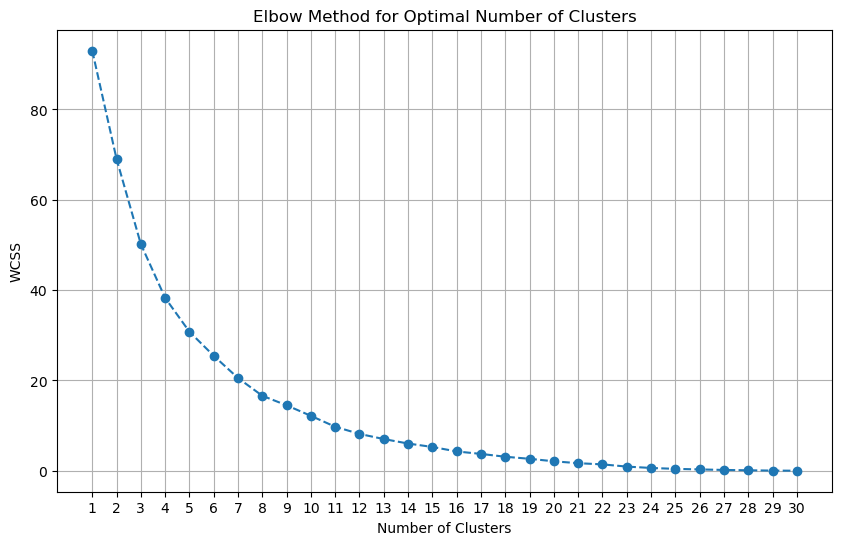

Enter the optimal number of clusters (as observed from the elbow plot): 10


,TEAM,%PTS FBPs,%PTS FT,%PTS OffTO,Cluster
0,Windy City Bulls,13.5 (12),7.5 (29),17.1 (15),"Low FBPs, Low FT Points"
1,Texas Legends,14.8 (5),7.3 (31),18.4 (7),"Low FBPs, Low FT Points"
2,College Park Skyhawks,14.7 (6),8.6 (19),17.3 (13),"Low FBPs, Low FT Points"
3,Motor City Cruise,14.2 (8),8.3 (23),16.7 (19),"Low FBPs, Low FT Points"
4,Delaware Blue Coats,11.5 (19),11.0 (1),20.8 (2),"Elite PTS OffTO, Good PTS FT, Good FBPs"
5,Stockton Kings,12.7 (16),8.4 (22),15.5 (24),"Good FBPs, Bad PTS FTs, High Points OffTO"
6,Valley Suns,11.1 (22),8.0 (27),15.4 (25),"Good FBPs, Bad PTS FTs, High Points OffTO"
7,Birmingham Squadron,10.4 (27),7.5 (29),14.3 (29),"Good FBPs, Bad PTS FTs, High Points OffTO"
8,Grand Rapids Gold,10.7 (25),8.1 (25),16.5 (21),"Good FBPs, Bad PTS FTs, High Points OffTO"
9,Long Island Nets,9.5 (29),10.9 (2),17.6 (10),"Average to Good FBPs, Good Points Off FT"


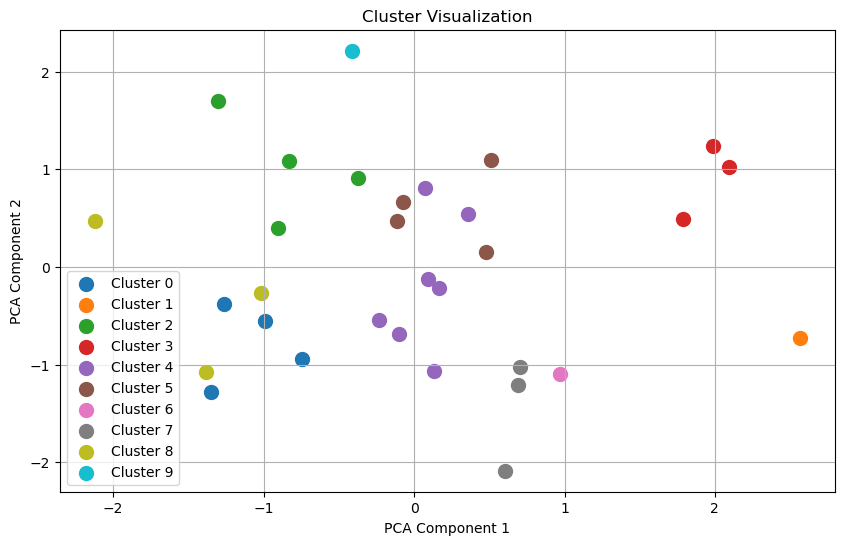

In [6]:
import os
import warnings
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from threadpoolctl import threadpool_limits
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
import time
from IPython.display import display

# Suppress MKL-related warning
warnings.filterwarnings("ignore", message="KMeans is known to have a memory leak", category=UserWarning)

# Set environment variable for MKL threads (optional, but may help)
os.environ["OMP_NUM_THREADS"] = "1"

# Set up Selenium WebDriver
service = Service("/Users/fadihaddad/Documents/chromedriver-mac-arm64/chromedriver")  # Update with your path

#Mac file path
#"/Users/fadihaddad/Documents/chromedriver-mac-arm64/chromedriver"

#PC file path
#r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe"

options = Options()
options.add_argument('--headless')  # Run in headless mode
options.add_argument('--disable-gpu')
options.add_argument('--start-maximized')
driver = webdriver.Chrome(service=service, options=options)

# URL of the webpage to scrape
url = "https://stats.gleague.nba.com/teams/scoring/?sort=W&dir=-1&Season=2024-25&SeasonType=Regular%20Season"

# Load the webpage
driver.get(url)
time.sleep(10)  # Allow time for JavaScript to load

# Locate the table and extract its data
table_xpath = '//div[contains(@class, "nba-stat-table__overflow")]/table'
table_element = driver.find_element(By.XPATH, table_xpath)
table_html = table_element.get_attribute('outerHTML')
team_stats = pd.read_html(table_html)[0]  # Convert the table HTML into a pandas DataFrame
driver.quit()  # Close the WebDriver

# Standardize column names: replace non-breaking spaces and strip whitespace
team_stats.columns = team_stats.columns.str.replace('\xa0', ' ', regex=False).str.strip()

# Keep only the specified columns
columns_to_keep = [
    'TEAM', '%PTS FBPs','%PTS FT', '%PTS OffTO'
]

#'2FGM %AST', '2FGM %UAST', '3FGM %AST','3FGM %UAST', 'FGM %AST', 'FGM %UAST'

team_stats = team_stats[columns_to_keep]

# Identify numeric columns
numeric_cols = team_stats.select_dtypes(include=['number']).columns

# Standardize numeric data for clustering
scaler = StandardScaler()
scaled_data = scaler.fit_transform(team_stats[numeric_cols])  # Standardize the numeric data

# Elbow Method: Compute WCSS for different numbers of clusters
wcss = []
max_clusters = 30  # Test up to 30 clusters
for i in range(1, max_clusters + 1):
    with threadpool_limits(limits=1, user_api='blas'):  # Limit MKL threads
        kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
        kmeans.fit(scaled_data)  # Use scaled data
        wcss.append(kmeans.inertia_)  # WCSS (Within-Cluster Sum of Squares)

# Plot the elbow method
plt.figure(figsize=(10, 6))
plt.plot(range(1, max_clusters + 1), wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.xticks(range(1, max_clusters + 1))
plt.grid()
plt.show()

# Prompt user to enter the optimal number of clusters (based on the elbow chart)
optimal_clusters = int(input("Enter the optimal number of clusters (as observed from the elbow plot): "))

# Perform K-Means clustering
with threadpool_limits(limits=1, user_api='blas'):
    kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(scaled_data)  # Use scaled data

# Add cluster labels to the DataFrame
df_with_ranks = team_stats.copy()  # Use original data for display
df_with_ranks['Cluster'] = cluster_labels

# Sort the DataFrame by the Cluster column in ascending order
df_with_ranks = df_with_ranks.sort_values(by='Cluster', ascending=True).reset_index(drop=True)

# Calculate ranks for numeric columns
ranks_data = {}
for col in numeric_cols:
    ranks = df_with_ranks[col].rank(ascending=False, method='min').astype(int)  # Higher is better for all columns
    df_with_ranks[col] = df_with_ranks[col].astype(str) + ' (' + ranks.astype(str) + ')'
    ranks_data[col] = ranks  # Store ranks for conditional formatting

# Define luminance function for text readability
def luminance(color):
    rgb = mcolors.hex2color(color)
    return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

# Define color_cells function for conditional formatting
def color_cells(row):
    colors = []
    for col in numeric_cols:
        rank = ranks_data[col].loc[row.name]
        max_rank = ranks_data[col].max()
        min_rank = ranks_data[col].min()
        # Normalize rank to 0-1 scale for color mapping
        norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
        color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Best ranks in green
        text_color = 'white' if luminance(color) < 0.5 else 'black'
        colors.append(f"background-color: {color}; color: {text_color};")
    return colors

# Apply the coloring logic to the sorted DataFrame
styled_df = df_with_ranks.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

# Rename clusters at the end
cluster_names = {
    0: "Low FBPs, Low FT Points", 
    1: "Elite PTS OffTO, Good PTS FT, Good FBPs", 
    2: "Good FBPs, Bad PTS FTs, High Points OffTO", 
    3: "Average to Good FBPs, Good Points Off FT", 
    4: "Elite PTS OffTO, Bad PTS OffTO, and Bad PTS Off FT", 
    5: "Good FBPs, Good FT Points Elite, PTS OffTO", 
    6: "Mediocre",
    7: "b",
}
df_with_ranks['Cluster'] = df_with_ranks['Cluster'].map(cluster_names)

# Display the styled DataFrame (sorted by clusters)
display(styled_df)

# Optional: Visualize the clusters using PCA
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(scaled_data)  # Use scaled data for visualization

plt.figure(figsize=(10, 6))
for cluster in range(optimal_clusters):
    cluster_points = reduced_data[cluster_labels == cluster]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster}", s=100)  # Use cluster number in legend
plt.title('Cluster Visualization')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.grid()
plt.show()

### Shooting

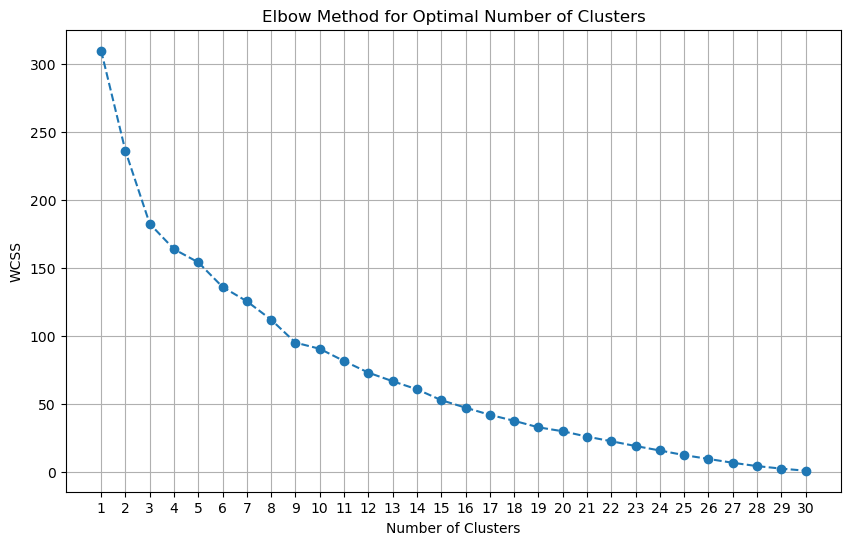

Enter the optimal number of clusters (as observed from the elbow plot): 9


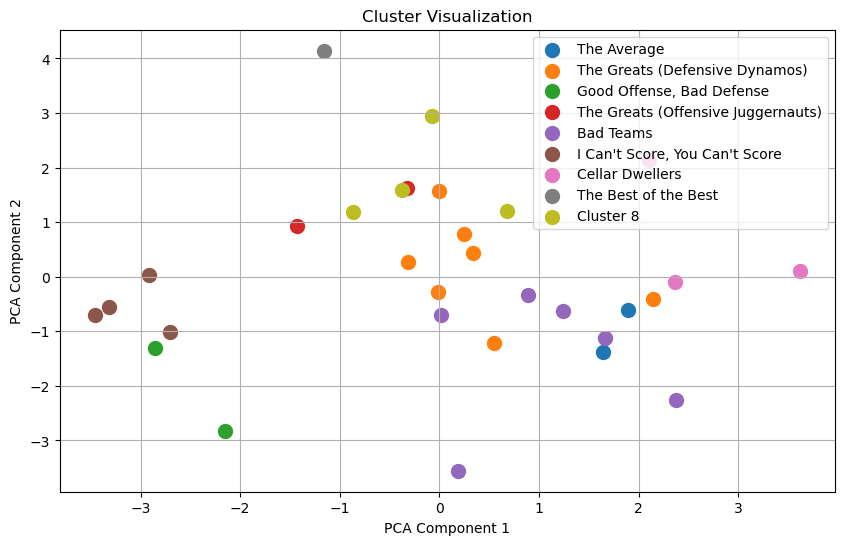

In [4]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from threadpoolctl import threadpool_limits
import warnings

# Suppress MKL-related warning
warnings.filterwarnings("ignore", message="KMeans is known to have a memory leak", category=UserWarning)

# Define the URL for the data request
url = "https://stats.gleague.nba.com/stats/leaguedashteamshotlocations"

# Define the headers for the network request
headers = {
    "Host": "stats.gleague.nba.com",
    "Connection": "keep-alive",
    "Accept": "application/json, text/plain, */*",
    "x-nba-stats-token": "true",
    "x-nba-stats-origin": "stats",
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    "Origin": "https://stats.gleague.nba.com",
    "Referer": "https://stats.gleague.nba.com/",
}

# Define the query parameters for "By Zone"
params = {
    "Conference": "",
    "DateFrom": "",
    "DateTo": "",
    "DistanceRange": "By Zone",
    "Division": "",
    "GameScope": "",
    "GameSegment": "",
    "LastNGames": "0",
    "LeagueID": "20",
    "Location": "",
    "MeasureType": "Base",
    "Month": "0",
    "OpponentTeamID": "0",
    "Outcome": "",
    "PORound": "0",
    "PaceAdjust": "N",
    "PerMode": "PerGame",
    "Period": "0",
    "PlayerExperience": "",
    "PlayerPosition": "",
    "PlusMinus": "N",
    "Rank": "N",
    "Season": "2024-25",
    "SeasonSegment": "",
    "SeasonType": "Regular Season",
    "ShotClockRange": "",
    "StarterBench": "",
    "TeamID": "0",
    "VsConference": "",
    "VsDivision": "",
}

# Send the GET request
response = requests.get(url, headers=headers, params=params)

# Verify if the request was successful
if response.status_code == 200:
    data = response.json()

    # Extract the relevant data
    result_set = data["resultSets"]["rowSet"]
    lower_level_columns = data["resultSets"]["headers"][1]["columnNames"]  # Lower-level columns (FGM, FGA, FG%)
    top_level_columns = data["resultSets"]["headers"][0]["columnNames"]  # Top-level columns (Shot categories)

    # Convert to a DataFrame
    team_stats = pd.DataFrame(result_set, columns=lower_level_columns)

    # Drop the TEAM_ID column
    if "TEAM_ID" in team_stats.columns:
        team_stats = team_stats.drop(columns=["TEAM_ID"])

    # Rename FG_PCT to FG% and TEAM_NAME to TEAM
    team_stats = team_stats.rename(columns=lambda x: x.replace("FG_PCT", "FG%") if "FG_PCT" in x else x)
    team_stats = team_stats.rename(columns={"TEAM_NAME": "TEAM"})

    # Drop the FGM columns for each shot category
    # Each shot category has 3 columns: FGM, FGA, FG%
    # We drop the FGM columns (every 3rd column starting from index 2)
    fgm_columns = [col for i, col in enumerate(team_stats.columns) if (i - 2) % 3 == 0]
    team_stats = team_stats.drop(columns=fgm_columns)

    # Create the MultiIndex columns
    # Each shot category has 2 columns (FGA, FG%) since we dropped FGM
    top_level = []
    lower_level = []
    for i, category in enumerate(top_level_columns):
        top_level.extend([category] * 2)  # Repeat each category 2 times (for FGA and FG%)
        lower_level.extend(["FGA", "FG%"])

    # Add the TEAM column to the MultiIndex
    top_level.insert(0, " ")  # Top-level for TEAM
    lower_level.insert(0, "TEAM")  # Lower-level for TEAM

    # Apply the MultiIndex to the DataFrame
    team_stats.columns = pd.MultiIndex.from_tuples(zip(top_level, lower_level))

    # Drop the "Left Corner 3", "Right Corner 3", and "Backcourt" columns
    zones_to_drop = ["Left Corner 3", "Right Corner 3", "Backcourt"]
    for zone in zones_to_drop:
        if zone in team_stats.columns.levels[0]:  # Check if the zone exists in the top-level columns
            team_stats = team_stats.drop(columns=zone, level=0)

    # Prepare data for clustering
    # Exclude the TEAM column and use all other columns
    numeric_cols = [col for col in team_stats.columns if col[1] in ["FGA", "FG%"]]
    clustering_data = team_stats[numeric_cols].astype(float)

    # Standardize the data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(clustering_data)

    # Elbow Method: Compute WCSS for different numbers of clusters
    wcss = []
    max_clusters = 30  # Test up to 30 clusters
    for i in range(1, max_clusters + 1):
        with threadpool_limits(limits=1, user_api='blas'):  # Limit MKL threads
            kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
            kmeans.fit(scaled_data)
            wcss.append(kmeans.inertia_)  # WCSS (Within-Cluster Sum of Squares)

    # Plot the elbow method
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, max_clusters + 1), wcss, marker='o', linestyle='--')
    plt.title('Elbow Method for Optimal Number of Clusters')
    plt.xlabel('Number of Clusters')
    plt.ylabel('WCSS')
    plt.xticks(range(1, max_clusters + 1))
    plt.grid()
    plt.show()

    # Prompt user to enter the optimal number of clusters (based on the elbow chart)
    optimal_clusters = int(input("Enter the optimal number of clusters (as observed from the elbow plot): "))

    # Perform K-Means clustering
    with threadpool_limits(limits=1, user_api='blas'):
        kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(scaled_data)

    # Add cluster labels to the DataFrame
    team_stats['Cluster'] = cluster_labels

    # Sort the DataFrame by the Cluster column in ascending order
    team_stats = team_stats.sort_values(by='Cluster', ascending=True).reset_index(drop=True)

    # Apply conditional formatting and ranking
    df_with_ranks = team_stats.copy()
    ranks_data = {}

    for col in numeric_cols:
        ranks = team_stats[col].rank(ascending=False, method='min').astype(int)
        df_with_ranks[col] = team_stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
        ranks_data[col] = ranks

    def luminance(color):
        rgb = mcolors.hex2color(color)
        return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

    def color_cells(row):
        colors = []
        for col in numeric_cols:
            rank = ranks_data[col].loc[row.name]
            max_rank = ranks_data[col].max()
            min_rank = ranks_data[col].min()
            norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
            color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))
            text_color = 'white' if luminance(color) < 0.5 else 'black'
            colors.append(f"background-color: {color}; color: {text_color};")
        return colors

    styled_df = df_with_ranks.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

    # Rename clusters at the end
    cluster_names = {
        0: "The Average", 
        1: "The Greats (Defensive Dynamos)", 
        2: "Good Offense, Bad Defense", 
        3: "The Greats (Offensive Juggernauts)", 
        4: "Bad Teams", 
        5: "I Can't Score, You Can't Score", 
        6: "Cellar Dwellers",
        7: "The Best of the Best"
    }
    df_with_ranks['Cluster'] = df_with_ranks['Cluster'].map(cluster_names)

    # Display the styled DataFrame (sorted by clusters)
    from IPython.display import display
    display(styled_df)

    # Optional: Visualize the clusters using PCA
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(scaled_data)

    plt.figure(figsize=(10, 6))
    for cluster in range(optimal_clusters):
        cluster_points = reduced_data[cluster_labels == cluster]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=cluster_names.get(cluster, f"Cluster {cluster}"), s=100)
    plt.title('Cluster Visualization')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend()
    plt.grid()
    plt.show()

In [3]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define the URL for the data request
url = "https://stats.gleague.nba.com/stats/leaguedashteamshotlocations"

# Define the headers for the network request
headers = {
    "Host": "stats.gleague.nba.com",
    "Connection": "keep-alive",
    "Accept": "application/json, text/plain, */*",
    "x-nba-stats-token": "true",
    "x-nba-stats-origin": "stats",
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    "Origin": "https://stats.gleague.nba.com",
    "Referer": "https://stats.gleague.nba.com/",
}

# Define the query parameters for "By Zone"
params = {
    "Conference": "",
    "DateFrom": "",
    "DateTo": "",
    "DistanceRange": "By Zone",
    "Division": "",
    "GameScope": "",
    "GameSegment": "",
    "LastNGames": "0",
    "LeagueID": "20",
    "Location": "",
    "MeasureType": "Base",
    "Month": "0",
    "OpponentTeamID": "0",
    "Outcome": "",
    "PORound": "0",
    "PaceAdjust": "N",
    "PerMode": "PerGame",
    "Period": "0",
    "PlayerExperience": "",
    "PlayerPosition": "",
    "PlusMinus": "N",
    "Rank": "N",
    "Season": "2024-25",
    "SeasonSegment": "",
    "SeasonType": "Regular Season",
    "ShotClockRange": "",
    "StarterBench": "",
    "TeamID": "0",
    "VsConference": "",
    "VsDivision": "",
}

# Send the GET request
response = requests.get(url, headers=headers, params=params)

# Verify if the request was successful
if response.status_code == 200:
    data = response.json()

    # Extract the relevant data
    result_set = data["resultSets"]["rowSet"]
    lower_level_columns = data["resultSets"]["headers"][1]["columnNames"]  # Lower-level columns (FGM, FGA, FG%)
    top_level_columns = data["resultSets"]["headers"][0]["columnNames"]  # Top-level columns (Shot categories)

    # Convert to a DataFrame
    team_stats = pd.DataFrame(result_set, columns=lower_level_columns)

    # Drop the TEAM_ID column
    if "TEAM_ID" in team_stats.columns:
        team_stats = team_stats.drop(columns=["TEAM_ID"])

    # Rename FG_PCT to FG% and TEAM_NAME to TEAM
    team_stats = team_stats.rename(columns=lambda x: x.replace("FG_PCT", "FG%") if "FG_PCT" in x else x)
    team_stats = team_stats.rename(columns={"TEAM_NAME": "TEAM"})

    # Create the MultiIndex columns
    # Each shot category has 3 columns (FGM, FGA, FG%)
    top_level = []
    lower_level = []
    for i, category in enumerate(top_level_columns):
        top_level.extend([category] * 2)  # Repeat each category 3 times
        lower_level.extend(["FGA", "FG%"])

    # Add the TEAM column to the MultiIndex
    top_level.insert(0, " ")  # Top-level for TEAM
    lower_level.insert(0, "TEAM")  # Lower-level for TEAM

    # Drop the FGM columns for each shot category
    # Each shot category has 3 columns: FGM, FGA, FG%
    # We drop the FGM columns (every 3rd column starting from index 2)
    fgm_columns = [col for i, col in enumerate(team_stats.columns) if (i - 2) % 3 == 0]
    team_stats = team_stats.drop(columns=fgm_columns)

    # Create the MultiIndex columns
    # Each shot category has 2 columns (FGA, FG%) since we dropped FGM
    top_level = []
    lower_level = []
    for i, category in enumerate(top_level_columns):
        top_level.extend([category] * 2)  # Repeat each category 2 times (for FGA and FG%)
        lower_level.extend(["FGA", "FG%"])

    # Add the TEAM column to the MultiIndex
    top_level.insert(0, " ")  # Top-level for TEAM
    lower_level.insert(0, "TEAM")  # Lower-level for TEAM

    # Apply the MultiIndex to the DataFrame
    team_stats.columns = pd.MultiIndex.from_tuples(zip(top_level, lower_level))

    # Drop the "Left Corner 3", "Right Corner 3", and "Backcourt" columns
    zones_to_drop = ["Left Corner 3", "Right Corner 3", "Backcourt"]
    for zone in zones_to_drop:
        if zone in team_stats.columns.levels[0]:  # Check if the zone exists in the top-level columns
            team_stats = team_stats.drop(columns=zone, level=0)

    # Apply conditional formatting and ranking
    numeric_cols = [col for col in team_stats.columns if col[1] in ["FGA", "FG%"]]
    df_with_ranks = team_stats.copy()
    ranks_data = {}

    for col in numeric_cols:
        ranks = team_stats[col].rank(ascending=False, method='min').astype(int)
        df_with_ranks[col] = team_stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
        ranks_data[col] = ranks

    def luminance(color):
        rgb = mcolors.hex2color(color)
        return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

    def color_cells(row):
        colors = []
        for col in numeric_cols:
            rank = ranks_data[col].loc[row.name]
            max_rank = ranks_data[col].max()
            min_rank = ranks_data[col].min()
            norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
            color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))
            text_color = 'white' if luminance(color) < 0.5 else 'black'
            colors.append(f"background-color: {color}; color: {text_color};")
        return colors

    styled_df = df_with_ranks.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

    from IPython.display import display
    display(styled_df)

In [28]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define the URL for the data request
url = "https://stats.gleague.nba.com/stats/leaguedashteamshotlocations"

# Define the headers for the network request
headers = {
    "Host": "stats.gleague.nba.com",
    "Connection": "keep-alive",
    "Accept": "application/json, text/plain, */*",
    "x-nba-stats-token": "true",
    "x-nba-stats-origin": "stats",
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    "Origin": "https://stats.gleague.nba.com",
    "Referer": "https://stats.gleague.nba.com/",
}

# Define the query parameters for "By Zone"
params = {
    "Conference": "",
    "DateFrom": "",
    "DateTo": "",
    "DistanceRange": "By Zone",
    "Division": "",
    "GameScope": "",
    "GameSegment": "",
    "LastNGames": "0",
    "LeagueID": "20",
    "Location": "",
    "MeasureType": "Base",
    "Month": "0",
    "OpponentTeamID": "0",
    "Outcome": "",
    "PORound": "0",
    "PaceAdjust": "N",
    "PerMode": "PerGame",
    "Period": "0",
    "PlayerExperience": "",
    "PlayerPosition": "",
    "PlusMinus": "N",
    "Rank": "N",
    "Season": "2024-25",
    "SeasonSegment": "",
    "SeasonType": "Regular Season",
    "ShotClockRange": "",
    "StarterBench": "",
    "TeamID": "0",
    "VsConference": "",
    "VsDivision": "",
}

# Send the GET request
response = requests.get(url, headers=headers, params=params)

# Verify if the request was successful
if response.status_code == 200:
    data = response.json()

    # Extract the relevant data
    result_set = data["resultSets"]["rowSet"]
    lower_level_columns = data["resultSets"]["headers"][1]["columnNames"]  # Lower-level columns (FGM, FGA, FG%)
    top_level_columns = data["resultSets"]["headers"][0]["columnNames"]  # Top-level columns (Shot categories)

    # Convert to a DataFrame
    team_stats = pd.DataFrame(result_set, columns=lower_level_columns)

    # Drop the TEAM_ID column
    if "TEAM_ID" in team_stats.columns:
        team_stats = team_stats.drop(columns=["TEAM_ID"])

    # Rename FG_PCT to FG% and TEAM_NAME to TEAM
    team_stats = team_stats.rename(columns=lambda x: x.replace("FG_PCT", "FG%") if "FG_PCT" in x else x)
    team_stats = team_stats.rename(columns={"TEAM_NAME": "TEAM"})

    # Drop the FGM columns for each shot category
    # Each shot category has 3 columns: FGM, FGA, FG%
    # We drop the FGM columns (every 3rd column starting from index 2)
    fgm_columns = [col for i, col in enumerate(team_stats.columns) if (i - 2) % 3 == 0]
    team_stats = team_stats.drop(columns=fgm_columns)

    # Create the MultiIndex columns
    # Each shot category has 2 columns (FGA, FG%) since we dropped FGM
    top_level = []
    lower_level = []
    for i, category in enumerate(top_level_columns):
        top_level.extend([category] * 2)  # Repeat each category 2 times (for FGA and FG%)
        lower_level.extend(["FGA", "FG%"])

    # Add the TEAM column to the MultiIndex
    top_level.insert(0, " ")  # Top-level for TEAM
    lower_level.insert(0, "TEAM")  # Lower-level for TEAM

    # Apply the MultiIndex to the DataFrame
    team_stats.columns = pd.MultiIndex.from_tuples(zip(top_level, lower_level))

    # Drop the "Left Corner 3", "Right Corner 3", and "Backcourt" columns
    zones_to_drop = ["Left Corner 3", "Right Corner 3", "Backcourt"]
    for zone in zones_to_drop:
        if zone in team_stats.columns.levels[0]:  # Check if the zone exists in the top-level columns
            team_stats = team_stats.drop(columns=zone, level=0)

    # Display the DataFrame
    print(team_stats)

    # ... [Keep the rest of the code for styling and formatting] ...

                               Restricted Area        In The Paint (Non-RA)  \
                          TEAM             FGA    FG%                   FGA   
0                 Austin Spurs            17.0  0.648                   8.4   
1          Birmingham Squadron            18.3  0.571                   7.0   
2           Capital City Go-Go            15.7  0.709                  10.6   
3   Ciudad de Mexico Capitanes            16.9  0.655                   5.3   
4             Cleveland Charge            21.2  0.660                   4.4   
5        College Park Skyhawks            17.6  0.613                   6.2   
6          Delaware Blue Coats            17.0  0.578                   6.8   
7            Grand Rapids Gold            12.4  0.629                  11.8   
8             Greensboro Swarm            15.6  0.663                   9.4   
9             Indiana Mad Ants            15.5  0.669                   9.8   
10                 Iowa Wolves            19.6  0.68

## Traditional

In [4]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import time

# Set up Selenium WebDriver
service = Service("/Users/fadihaddad/Documents/chromedriver-mac-arm64/chromedriver")  # Update with your path to chromedriver

#Mac file path
#"/Users/fadihaddad/Documents/chromedriver-mac-arm64/chromedriver"

#PC file path
#r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe"

options = Options()
options.add_argument('--headless')  # Run in headless mode
options.add_argument('--disable-gpu')
options.add_argument('--start-maximized')

driver = webdriver.Chrome(service=service, options=options)

# URL of the webpage to scrape
url = "https://stats.gleague.nba.com/teams/traditional/?sort=W_PCT&dir=-1&Season=2024-25&SeasonType=Regular%20Season"

# Load the webpage
driver.get(url)

# Allow time for JavaScript to load
time.sleep(10)  # Adjust the time as per your internet speed and website response time

# Locate the table
table_xpath = '//div[contains(@class, "nba-stat-table__overflow")]/table'
table_element = driver.find_element(By.XPATH, table_xpath)

# Extract the table data
table_html = table_element.get_attribute('outerHTML')

# Convert the table HTML into a pandas DataFrame
team_stats = pd.read_html(table_html)[0]

# Quit the driver
driver.quit()

# Drop the specified columns
columns_to_drop = [
    'Unnamed: 0', 'GP', 'W', 'L', 'WIN%', 'MIN', 'GP RANK', 'W RANK', 'L RANK', 'WIN% RANK', 'MIN RANK', 'PTS RANK',
    'FGM RANK', 'FGA RANK', 'FG% RANK', '3PM RANK', '3PA RANK', '3P% RANK',
    'FTM RANK', 'FTA RANK', 'FT% RANK', 'OREB RANK', 'DREB RANK',
    'REB RANK', 'AST RANK', 'TOV RANK', 'STL RANK', 'BLK RANK', 'BLKA RANK',
    'PF RANK', 'PFD RANK', '+/- RANK'
]
team_stats = team_stats.drop(columns=[col for col in columns_to_drop if col in team_stats.columns])

# Ensure numeric columns are correctly identified
numeric_cols = team_stats.select_dtypes(include=['number']).columns

# Calculate ranks and append ranks to numeric columns for display
invert_cols = ['TOV', 'BLKA', 'PF']  # PF will be descending, all others ascending
df_with_ranks = team_stats.copy()
ranks_data = {}

# Calculate ranks for numeric columns
for col in numeric_cols:
    if col in invert_cols:
        ranks = team_stats[col].rank(ascending=True, method='min').astype(int)  # Lower is better for inverted columns
    else:
        ranks = team_stats[col].rank(ascending=False, method='min').astype(int)  # Higher is better for regular columns
    df_with_ranks[col] = team_stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
    ranks_data[col] = ranks  # Store ranks for color mapping

# Define luminance function for text color adjustment
def luminance(color):
    rgb = mcolors.hex2color(color)
    return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

# Adjusted color_cells function to use ranks for color scaling
def color_cells(row):
    colors = []
    for col in numeric_cols:
        rank = ranks_data[col].loc[row.name]
        max_rank = ranks_data[col].max()
        min_rank = ranks_data[col].min()
        # Normalize rank to 0-1 scale for color mapping
        norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
        # Map normalized rank to color
        color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Invert to make 1 (best) green
        # Adjust text color for readability
        text_color = 'white' if luminance(color) < 0.5 else 'black'
        colors.append(f"background-color: {color}; color: {text_color};")
    return colors

# Apply the coloring logic to the DataFrame with ranks
styled_df = df_with_ranks.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

# Display the styled DataFrame
styled_df

,TEAM,PTS,FGM,FGA,FG%,3PM,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,+/-
0,Santa Cruz Warriors,115.3 (8),42.0 (6),89.9 (9),46.7 (11),16.0 (2),40.0 (8),40.0 (3),9.4 (23),12.9 (21),73.3 (13),13.4 (9),37.6 (1),51.0 (1),28.3 (3),17.0 (15),6.7 (30),5.9 (12),5.9 (20),18.6 (12),17.7 (24),3.6 (12)
1,Stockton Kings,116.5 (6),42.6 (5),88.8 (16),48.0 (7),14.9 (6),38.1 (15),39.0 (4),10.0 (18),14.5 (11),69.0 (22),13.0 (11),35.4 (7),48.4 (5),25.5 (12),15.8 (10),8.0 (25),7.5 (3),3.8 (2),20.5 (25),17.9 (23),7.3 (5)
2,College Park Skyhawks,110.9 (17),39.3 (24),89.7 (11),43.8 (27),14.3 (9),40.9 (5),35.0 (16),10.4 (14),12.3 (25),84.9 (1),10.7 (21),33.4 (16),44.1 (21),24.1 (16),12.4 (1),10.3 (7),5.4 (15),5.3 (10),18.3 (11),18.1 (21),5.6 (6)
3,Greensboro Swarm,104.3 (27),37.4 (29),84.7 (27),44.2 (23),9.7 (29),28.4 (29),34.2 (21),11.3 (6),13.6 (18),83.2 (2),12.9 (12),33.6 (14),46.4 (10),21.3 (29),15.1 (6),8.3 (22),3.9 (29),6.0 (22),16.9 (5),18.4 (19),9.0 (3)
4,Raptors 905,114.7 (10),40.7 (14),85.7 (23),47.5 (8),13.1 (16),31.6 (28),41.6 (1),11.4 (5),16.7 (5),68.4 (25),11.3 (18),35.6 (6),46.9 (8),28.7 (1),18.6 (27),8.9 (15),5.4 (15),6.7 (27),24.4 (30),22.0 (4),5.0 (7)
5,Indiana Mad Ants,118.4 (4),44.3 (2),87.7 (22),50.5 (1),13.1 (16),33.6 (25),39.0 (4),9.5 (22),12.1 (26),78.5 (5),9.9 (25),33.0 (18),42.9 (25),28.5 (2),15.5 (9),8.1 (24),5.5 (14),5.8 (19),16.8 (3),17.4 (25),5.0 (7)
6,Ciudad de Mexico Capitanes,111.2 (15),40.7 (14),84.3 (28),48.2 (6),13.3 (15),36.2 (20),36.9 (8),10.8 (12),13.7 (16),79.3 (4),8.5 (31),36.2 (2),44.7 (19),23.3 (21),17.2 (18),9.5 (12),5.7 (13),3.2 (1),24.8 (31),21.0 (8),9.2 (2)
7,San Diego Clippers,109.8 (19),40.6 (16),90.5 (7),44.9 (20),11.3 (26),34.5 (24),32.6 (27),9.8 (20),14.0 (13),69.6 (21),13.5 (8),34.1 (13),47.6 (6),22.6 (27),17.1 (16),10.5 (6),6.9 (8),7.9 (31),20.6 (27),19.3 (13),4.9 (9)
8,Capital City Go-Go,116.9 (5),41.9 (9),84.1 (29),49.7 (2),15.6 (3),38.7 (13),40.2 (2),10.9 (11),14.4 (12),75.2 (9),9.6 (27),32.3 (22),41.9 (29),27.7 (5),17.3 (19),9.0 (13),7.1 (7),4.7 (6),19.4 (17),20.0 (11),8.0 (4)
9,Salt Lake City Stars,114.4 (11),40.1 (19),89.4 (13),44.9 (20),12.9 (18),37.0 (18),34.7 (19),12.6 (1),17.0 (4),73.9 (11),16.4 (1),29.1 (29),45.6 (14),22.9 (25),18.0 (25),10.9 (5),4.1 (25),5.3 (10),20.3 (22),21.3 (7),-4.7 (23)


## Advanced Stats

In [5]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import time

# Set up Selenium WebDriver
service = Service("/Users/fadihaddad/Documents/chromedriver-mac-arm64/chromedriver")  # Update with your path to chromedriver

#Mac file path
#"/Users/fadihaddad/Documents/chromedriver-mac-arm64/chromedriver"

#PC file path
#r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe"

options = Options()
options.add_argument('--headless')  # Run in headless mode
options.add_argument('--disable-gpu')
options.add_argument('--start-maximized')

driver = webdriver.Chrome(service=service, options=options)

# URL of the webpage to scrape
url = "https://stats.gleague.nba.com/teams/advanced/?sort=W&dir=-1&Season=2024-25&SeasonType=Regular%20Season"

# Load the webpage
driver.get(url)

# Allow time for JavaScript to load
time.sleep(10)  # Adjust the time as per your internet speed and website response time

# Locate the table
table_xpath = '//div[contains(@class, "nba-stat-table__overflow")]/table'
table_element = driver.find_element(By.XPATH, table_xpath)

# Extract the table data
table_html = table_element.get_attribute('outerHTML')

# Convert the table HTML into a pandas DataFrame
team_stats = pd.read_html(table_html)[0]

# Quit the driver
driver.quit()

# Drop the specified columns
columns_to_drop = [
    'Unnamed: 0', 'GP', 'W', 'L', 'WIN%', 'MIN', 'GP RANK', 'W RANK', 'L RANK',
    'MIN RANK', 'OffRtg RANK', 'DefRtg RANK', 'NetRtg RANK', 'AST% RANK',
    'AST/TO RANK', 'AST Ratio RANK', 'OREB% RANK', 'DREB% RANK',
    'REB% RANK', 'TO Ratio RANK', 'eFG% RANK', 'TS% RANK', 'PACE RANK',
    'PIE RANK'
]
team_stats = team_stats.drop(columns=[col for col in columns_to_drop if col in team_stats.columns])

# Ensure numeric columns are correctly identified
numeric_cols = team_stats.select_dtypes(include=['number']).columns

# Calculate ranks and append ranks to numeric columns for display
invert_cols = ['DefRtg', 'TOV%']  # Invert ranks for specified columns
df_with_ranks = team_stats.copy()
ranks_data = {}

# Calculate ranks for numeric columns
for col in numeric_cols:
    if col in invert_cols:
        ranks = team_stats[col].rank(ascending=True, method='min').astype(int)  # Lower is better for inverted columns
    else:
        ranks = team_stats[col].rank(ascending=False, method='min').astype(int)  # Higher is better for regular columns
    df_with_ranks[col] = team_stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
    ranks_data[col] = ranks  # Store ranks for color mapping

# Define luminance function for text color adjustment
def luminance(color):
    rgb = mcolors.hex2color(color)
    return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

# Adjusted color_cells function to use ranks for color scaling
def color_cells(row):
    colors = []
    for col in numeric_cols:
        rank = ranks_data[col].loc[row.name]
        max_rank = ranks_data[col].max()
        min_rank = ranks_data[col].min()
        # Normalize rank to 0-1 scale for color mapping
        norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
        # Map normalized rank to color
        color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Invert to make 1 (best) green
        # Adjust text color for readability
        text_color = 'white' if luminance(color) < 0.5 else 'black'
        colors.append(f"background-color: {color}; color: {text_color};")
    return colors

# Apply the coloring logic to the DataFrame with ranks
styled_df = df_with_ranks.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

# Display the styled DataFrame
styled_df

,TEAM,OffRtg,DefRtg,NetRtg,AST%,AST/TO,AST Ratio,OREB%,DREB%,REB%,TOV%,eFG%,TS%,PACE,PIE
0,Indiana Mad Ants,118.5 (1),114.0 (25),4.5 (8),64.3 (7),1.84 (3),19.9 (1),32.8 (11),69.7 (14),52.2 (5),15.5 (8),58.0 (2),63.6 (3),99.2 (25),53.1 (8)
1,Santa Cruz Warriors,112.7 (9),110.6 (18),2.1 (13),67.3 (3),1.66 (6),19.3 (4),32.4 (13),72.8 (3),53.4 (3),16.6 (14),55.6 (7),60.3 (8),101.64 (11),52.5 (11)
2,Stockton Kings,116.4 (4),108.8 (13),7.5 (5),59.8 (16),1.62 (8),18.0 (12),32.4 (13),67.0 (24),50.6 (12),15.7 (9),56.4 (5),61.2 (6),100.25 (17),53.4 (6)
3,College Park Skyhawks,112.8 (8),107.3 (9),5.5 (6),61.5 (10),1.94 (1),17.6 (14),28.9 (22),67.3 (22),48.2 (27),12.6 (1),51.8 (24),58.3 (14),96.93 (29),53.4 (6)
4,Delaware Blue Coats,108.4 (20),110.1 (17),-1.7 (18),51.7 (31),1.53 (14),14.7 (30),30.8 (17),67.5 (21),47.7 (28),13.1 (4),49.3 (30),55.6 (30),100.06 (19),48.1 (20)
5,Greensboro Swarm,109.3 (13),100.0 (3),9.3 (2),56.9 (24),1.41 (18),16.0 (24),34.2 (6),73.0 (2),53.5 (1),15.9 (11),49.9 (29),57.5 (19),95.36 (30),55.2 (3)
6,Maine Celtics,108.4 (20),108.5 (12),-0.1 (16),59.5 (17),1.51 (15),16.6 (21),29.6 (20),69.9 (12),48.3 (26),15.2 (7),51.9 (22),57.1 (25),99.05 (26),48.7 (19)
7,Raptors 905,109.3 (13),104.9 (6),4.3 (10),70.5 (2),1.55 (13),19.4 (3),29.5 (21),70.5 (9),51.1 (10),17.7 (25),55.2 (8),61.6 (4),102.61 (8),52.7 (10)
8,San Diego Clippers,107.5 (27),102.9 (5),4.5 (8),55.7 (27),1.32 (25),15.9 (25),33.9 (7),65.6 (26),50.2 (14),16.8 (16),51.1 (27),56.8 (27),101.56 (12),53.1 (8)
9,Westchester Knicks,114.5 (6),118.0 (28),-3.5 (20),60.6 (14),1.68 (5),16.9 (19),38.5 (2),72.1 (4),53.5 (1),14.7 (6),51.6 (26),57.5 (19),103.63 (6),47.4 (23)


## Four Factors

In [6]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import time

# Set up Selenium WebDriver
service = Service("/Users/fadihaddad/Documents/chromedriver-mac-arm64/chromedriver")  # Update with your path to chromedriver

# Mac file path
# "/Users/fadihaddad/Documents/chromedriver-mac-arm64/chromedriver"

# PC file path
# r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe"

options = Options()
options.add_argument('--headless')  # Run in headless mode
options.add_argument('--disable-gpu')
options.add_argument('--start-maximized')

driver = webdriver.Chrome(service=service, options=options)

# URL of the webpage to scrape
url = "https://stats.gleague.nba.com/teams/four-factors/?sort=W_PCT&dir=-1&Season=2024-25&SeasonType=Regular%20Season"

# Load the webpage
driver.get(url)

# Allow time for JavaScript to load
time.sleep(10)  # Adjust the time as per your internet speed and website response time

# Locate the table
table_xpath = '//div[contains(@class, "nba-stat-table__overflow")]/table'
table_element = driver.find_element(By.XPATH, table_xpath)

# Extract the table data
table_html = table_element.get_attribute('outerHTML')

# Convert the table HTML into a pandas DataFrame
team_stats = pd.read_html(table_html)[0]

# Quit the driver
driver.quit()

# Standardize column names
team_stats.columns = team_stats.columns.str.replace('\xa0', ' ', regex=False).str.strip()

# Drop the specified columns
columns_to_drop = [
    'Unnamed: 0', 'GP', 'W', 'L', 'WIN%', 'MIN', 'GP RANK', 'W RANK', 'L RANK', 'MIN RANK', 'eFG% RANK', 'TO Ratio RANK',
    'OREB% RANK', 'Opp FTA Rate RANK', 'Opp To Ratio RANK', 'WIN% RANK', 'FTA Rate RANK', 'Opp eFG% RANK', 'Opp OREB% RANK'
]
team_stats = team_stats.drop(columns=[col for col in columns_to_drop if col in team_stats.columns])

# Ensure numeric columns are correctly identified
numeric_cols = team_stats.select_dtypes(include=['number']).columns

# Calculate ranks and append ranks to numeric columns for display
invert_cols = ['TOV%', 'Opp eFG%', 'Opp FTA Rate', 'Opp OREB%']  # Columns with descending rank
df_with_ranks = team_stats.copy()
ranks_data = {}

# Calculate ranks for numeric columns
for col in numeric_cols:
    if col in invert_cols:
        ranks = team_stats[col].rank(ascending=True, method='min').astype(int)  # Lower is better for inverted columns
    else:
        ranks = team_stats[col].rank(ascending=False, method='min').astype(int)  # Higher is better for regular columns
    df_with_ranks[col] = team_stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
    ranks_data[col] = ranks  # Store ranks for color mapping

# Define luminance function for text color adjustment
def luminance(color):
    rgb = mcolors.hex2color(color)
    return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

# Adjusted color_cells function to use ranks for color scaling
def color_cells(row):
    colors = []
    for col in numeric_cols:
        rank = ranks_data[col].loc[row.name]
        max_rank = ranks_data[col].max()
        min_rank = ranks_data[col].min()
        # Normalize rank to 0-1 scale for color mapping
        norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
        # Map normalized rank to color
        color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Invert to make 1 (best) green
        # Adjust text color for readability
        text_color = 'white' if luminance(color) < 0.5 else 'black'
        colors.append(f"background-color: {color}; color: {text_color};")
    return colors

# Apply the coloring logic to the DataFrame with ranks
styled_df = df_with_ranks.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

# Display the styled DataFrame
styled_df

,TEAM,eFG%,FTA Rate,TOV%,OREB%,Opp eFG%,Opp FTA Rate,Opp TOV%,Opp OREB%
0,Santa Cruz Warriors,55.6 (7),0.143 (23),16.6 (14),32.4 (13),52.2 (13),0.144 (12),12.3 (30),27.2 (3)
1,Stockton Kings,56.4 (5),0.163 (11),15.7 (9),32.4 (13),49.8 (8),0.167 (21),14.1 (26),33.0 (24)
2,College Park Skyhawks,51.8 (24),0.137 (25),12.6 (1),28.9 (22),51.5 (12),0.158 (18),17.5 (10),32.7 (22)
3,Greensboro Swarm,49.9 (29),0.16 (13),15.9 (11),34.2 (6),51.1 (10),0.133 (4),18.4 (5),27.0 (2)
4,Raptors 905,55.2 (8),0.195 (2),17.7 (25),29.5 (21),50.4 (9),0.218 (30),16.5 (17),29.5 (9)
5,Indiana Mad Ants,58.0 (2),0.138 (24),15.5 (8),32.8 (11),54.1 (17),0.132 (3),14.4 (25),30.3 (14)
6,Ciudad de Mexico Capitanes,56.1 (6),0.162 (12),16.9 (19),25.3 (29),47.4 (1),0.232 (31),16.8 (13),29.9 (10)
7,San Diego Clippers,51.1 (27),0.155 (15),16.8 (16),33.9 (7),48.3 (2),0.163 (19),18.2 (7),34.4 (26)
8,Capital City Go-Go,59.0 (1),0.171 (9),17.4 (21),28.2 (23),51.3 (11),0.149 (15),17.5 (10),37.0 (31)
9,Salt Lake City Stars,52.1 (20),0.19 (5),17.9 (27),39.6 (1),57.1 (29),0.171 (25),16.4 (18),35.0 (29)


## Scoring

In [7]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import time

# Set up Selenium WebDriver
service = Service("/Users/fadihaddad/Documents/chromedriver-mac-arm64/chromedriver")  # Update with your path to chromedriver

# Mac file path
# "/Users/fadihaddad/Documents/chromedriver-mac-arm64/chromedriver"

# PC file path
# r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe"

options = Options()
options.add_argument('--headless')  # Run in headless mode
options.add_argument('--disable-gpu')
options.add_argument('--start-maximized')

driver = webdriver.Chrome(service=service, options=options)

# URL of the webpage to scrape
url = "https://stats.gleague.nba.com/teams/scoring/?sort=W&dir=-1&Season=2024-25&SeasonType=Regular%20Season"

# Load the webpage
driver.get(url)

# Allow time for JavaScript to load
time.sleep(10)  # Adjust the time as per your internet speed and website response time

# Locate the table
table_xpath = '//div[contains(@class, "nba-stat-table__overflow")]/table'
table_element = driver.find_element(By.XPATH, table_xpath)

# Extract the table data
table_html = table_element.get_attribute('outerHTML')

# Convert the table HTML into a pandas DataFrame
team_stats = pd.read_html(table_html)[0]

# Quit the driver
driver.quit()

# Standardize column names
team_stats.columns = team_stats.columns.str.replace('\xa0', ' ', regex=False).str.strip()

# Drop the specified columns
columns_to_drop = [
    'Unnamed: 0', 'GP', 'W', 'L', 'MIN', 'GP RANK', 'W RANK', 'L RANK',
    'MIN RANK', '%FGA 2PT RANK', '%FGA 3PT RANK', '%PTS 2PT RANK',
    '%PTS 2PT- MR RANK', '%PTS 3PT RANK', '%PTS FBPs RANK', '%PTS FT RANK',
    '%PTS OffTO RANK', '%PTS PITP RANK', '2FGM %AST RANK',
    '2FGM %UAST RANK', '3FGM %AST RANK', '3FGM %UAST RANK', 'FGM %AST RANK',
    'FGM %UAST RANK'
]
team_stats = team_stats.drop(columns=[col for col in columns_to_drop if col in team_stats.columns])

# Ensure numeric columns are correctly identified
numeric_cols = team_stats.select_dtypes(include=['number']).columns

# Define invert columns (if any are needed in the future)
invert_cols = []  # Add column names here if inversion is needed
df_with_ranks = team_stats.copy()
ranks_data = {}

# Calculate ranks for numeric columns
for col in numeric_cols:
    if col in invert_cols:
        ranks = team_stats[col].rank(ascending=True, method='min').astype(int)  # Lower is better for inverted columns
    else:
        ranks = team_stats[col].rank(ascending=False, method='min').astype(int)  # Higher is better for regular columns
    df_with_ranks[col] = team_stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
    ranks_data[col] = ranks  # Store ranks for color mapping

# Define luminance function for text color adjustment
def luminance(color):
    rgb = mcolors.hex2color(color)
    return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

# Adjusted color_cells function to use ranks for color scaling
def color_cells(row):
    colors = []
    for col in numeric_cols:
        rank = ranks_data[col].loc[row.name]
        max_rank = ranks_data[col].max()
        min_rank = ranks_data[col].min()
        # Normalize rank to 0-1 scale for color mapping
        norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
        # Map normalized rank to color
        color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Invert to make 1 (best) green
        # Adjust text color for readability
        text_color = 'white' if luminance(color) < 0.5 else 'black'
        colors.append(f"background-color: {color}; color: {text_color};")
    return colors

# Apply the coloring logic to the DataFrame with ranks
styled_df = df_with_ranks.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

# Display the styled DataFrame
styled_df

,TEAM,%FGA 2PT,%FGA 3PT,%PTS 2PT,%PTS 2PT- MR,%PTS 3PT,%PTS FBPs,%PTS FT,%PTS OffTO,%PTS PITP,2FGM %AST,2FGM %UAST,3FGM %AST,3FGM %UAST,FGM %AST,FGM %UAST
0,Indiana Mad Ants,61.7 (7),38.3 (25),52.7 (8),8.3 (3),33.2 (23),11.7 (16),8.0 (25),17.2 (16),44.4 (16),52.6 (5),47.4 (27),92.4 (3),7.6 (29),64.3 (7),35.7 (24)
1,Santa Cruz Warriors,55.5 (23),44.5 (9),45.1 (26),6.4 (6),41.6 (4),8.6 (30),8.2 (23),12.8 (29),38.7 (29),50.0 (10),50.0 (22),95.5 (1),4.5 (31),67.3 (3),32.7 (29)
2,Stockton Kings,57.0 (18),43.0 (13),47.6 (22),5.2 (13),38.3 (10),10.7 (21),8.6 (22),15.0 (24),42.5 (24),46.4 (17),53.6 (15),84.9 (23),15.1 (9),59.8 (16),40.2 (16)
3,College Park Skyhawks,54.5 (26),45.5 (6),45.1 (26),2.8 (24),38.7 (7),17.3 (4),9.4 (11),19.2 (12),42.3 (25),49.7 (11),50.3 (21),82.0 (26),18.0 (6),61.5 (10),38.5 (21)
4,Delaware Blue Coats,60.7 (9),39.3 (22),52.4 (10),9.5 (1),29.3 (28),11.1 (19),11.2 (1),21.5 (5),43.0 (20),45.9 (20),54.1 (11),67.4 (31),32.6 (1),51.7 (31),48.3 (1)
5,Greensboro Swarm,66.4 (3),33.6 (29),53.2 (7),7.1 (5),27.9 (29),11.2 (18),10.8 (4),21.8 (3),46.0 (10),44.8 (25),55.2 (7),91.2 (6),8.8 (26),56.9 (24),43.1 (7)
6,Maine Celtics,53.4 (29),46.6 (3),45.5 (25),3.3 (22),38.6 (8),10.3 (24),10.2 (6),19.6 (10),42.2 (26),45.0 (24),55.0 (8),85.1 (20),14.9 (11),59.5 (17),40.5 (15)
7,Raptors 905,63.2 (5),36.8 (27),48.1 (18),1.5 (31),34.4 (18),13.9 (12),10.0 (7),20.0 (7),46.6 (9),60.6 (2),39.4 (30),91.3 (4),8.7 (27),70.5 (2),29.5 (30)
8,San Diego Clippers,61.9 (6),38.1 (26),53.5 (5),8.9 (2),30.8 (26),18.3 (2),8.9 (16),21.6 (4),44.6 (14),46.8 (16),53.2 (16),78.9 (29),21.1 (3),55.7 (27),44.3 (4)
9,Westchester Knicks,57.0 (18),43.0 (13),45.7 (24),2.6 (26),38.5 (9),14.6 (10),8.8 (20),12.6 (30),43.1 (19),45.7 (22),54.3 (9),87.1 (16),12.9 (16),60.6 (14),39.4 (18)
